In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models,regularizers
from tensorflow.keras.applications import ResNet101,ResNet50
import matplotlib.pyplot as plt
import pathlib
import random

# Creating writable path

In [3]:
import shutil

oral_path = "/kaggle/input/oral-cancer-images-for-classification/dataset"
oral_writing_path = "/kaggle/working/clean_dataset"

# Recursively copy the dataset to a writable directory
shutil.copytree(oral_path, oral_writing_path)

'/kaggle/working/clean_dataset'

# Testing images 


In [4]:
import tensorflow as tf
import os

def test_images(directory):
    bad_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg")):
                path = os.path.join(root, file)
                try:
                    raw = tf.io.read_file(path)
                    _ = tf.image.decode_jpeg(raw)  # Explicit JPEG decoder
                except Exception as e:
                    print(f"Corrupted or unsupported file: {path}")
                    print(f"Error: {e}")
                    bad_files.append(path)
    return bad_files

bad_images = test_images("/kaggle/working/clean_dataset")  # Change this path
print(f"\nTotal bad images: {len(bad_images)}")

2025-05-15 12:20:06.029319: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Corrupted or unsupported file: /kaggle/working/clean_dataset/Oral Cancer photos/492.jpeg
Error: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]
Corrupted or unsupported file: /kaggle/working/clean_dataset/Oral Cancer photos/205.jpeg
Error: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]
Corrupted or unsupported file: /kaggle/working/clean_dataset/Oral Cancer photos/426.jpeg
Error: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]
Corrupted or unsupported file: /kaggle/working/clean_dataset/Oral Cancer photos/456.jpeg
Error: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown 

# Deleting non valid images

In [7]:
for file in bad_images:
    os.remove(file)

In [5]:
IMG_SIZE = 224

# we tried smaller batch sizes but it didnot work too
BATCH_SIZE = 128

In [8]:
oral_dataset = tf.keras.utils.image_dataset_from_directory(
    oral_writing_path,
    seed=12,
    labels="inferred", # Labels from subfolders (e.g., "cat", "dog")
    image_size=(IMG_SIZE,IMG_SIZE),   # Resize images
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 1193 files belonging to 2 classes.


In [9]:
oral_dataset.class_names

['Oral Cancer photos', 'normal']

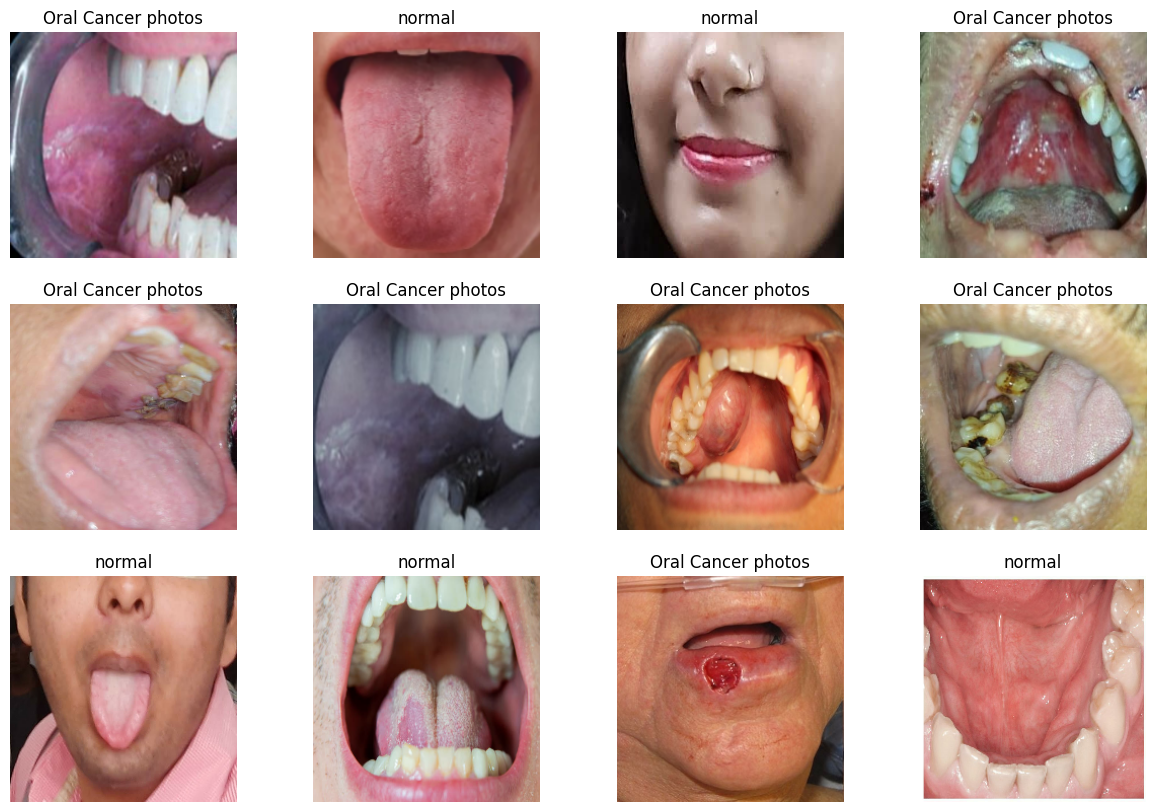

In [10]:
plt.figure(figsize=(15, 10))
for image_batch, labels_batch in oral_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(oral_dataset.class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
for image_batch, labels_batch in oral_dataset.take(1):
    print(image_batch.shape)

(128, 224, 224, 3)


In [12]:
print("Number of batches =",len(oral_dataset))

Number of batches = 10


# Spliting the data set

In [19]:
def get_dataset_partitions_tf(ds, train_part=0.8, validation_part=0.1, test_part=0.1, shuffle=True, shuffle_size=10000):
    assert (train_part + test_part + validation_part) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_part * ds_size)
    val_size = int(validation_part * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(oral_dataset)
print("Number of training batches is",len(train_ds))
print("Number of validation batches is",len(val_ds))
print("Number of testing batches is",len(test_ds))

Number of training batches is 30
Number of validation batches is 3
Number of testing batches is 5


# Data augmentation step

In [20]:
# Normalizing the image to range from 0 ==> 1 by dividing by 255
resizing_rescaling = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),  
    layers.Rescaling(1./255),                 
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip(mode="horizontal_and_vertical"),
    layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    layers.RandomRotation(factor=0.2),
])

# Getting the pre-trained model of ResNet50 

In [15]:
# we firstly tried the ResNet101 as the paper but it didnot work so we tried this
base_model = ResNet50(
    weights='/kaggle/input/resnet50/keras/default/1/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
    include_top=False,
    input_shape=(224, 224, 3)
)


# Freeze upper layers in ResNet Model

In [16]:
#Set trainable=False by default
for layer in base_model.layers:
    layer.trainable = False

# count = 0
#Set trainable=True for layers from conv4_block1 onward
trainable = False
for layer in base_model.layers:
    if layer.name == "conv4_block1_1_conv":
        trainable = True
    layer.trainable = trainable
    # if layer.trainable == True:
    #     count = count +1
# count

In [17]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)


0 input_layer
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_

# Our Model

In [22]:
model = models.Sequential([
    base_model,
    resizing_rescaling,
    data_augmentation,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

In [23]:
from tensorflow.keras.optimizers import SGD

optimizer = SGD(learning_rate=0.001, momentum=0.9)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.fit(
    train_ds,
    validation_data=val_ds,
    verbose = 1,
    epochs=100,
    batch_size=128
)